# MNIST Data Setup
Here we will use the MNIST data set to train a basic neural network in pytorch

In [1]:
from pathlib import Path
import requests

# This code just requests the data from the github repo 
# and stores it in the directory. It also creates that directory if it does not
# yet exist
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

# This code just opens the data from the pickle format so that it is python readable
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

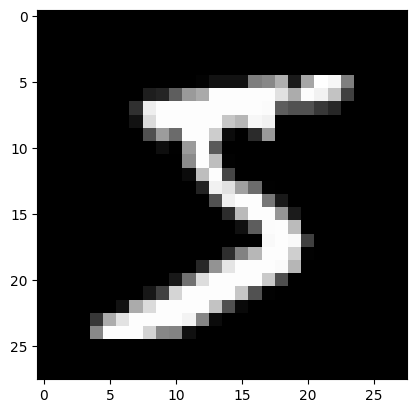

(50000, 784)


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Plot an example image from the dataset
# This code right here just takes the 784 array of pixel values and reshapes it
# into a 28 * 28 array so that it can be displayed by plt
plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")

plt.show()

# The shape of the data means that there are exactly 50,000 images, each of which 
# consists of exactly 784 pixels
print(x_train.shape)

# Create the training and validation split
This code below will be used to divide up the data into data for training the model and data for validating the accuracy of the model

In [4]:
import torch

# This just converts our np array of pixel values into tensors, which can be 
# more easily interacted with in pytorch
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

# This returns the data within the training inputs and outputs
print(x_train, y_train)

# the shape of the input data is like above. 50,000 images of 784 pixels each
print(x_train.shape)

# The training data is a single dimensional vector each corresponding to what the input data
# corresponds to
# So the output values can range from 0-9
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# Neural Net from scratch
Here we will not subclass torch.nn to get a good look into how the classes and functions make our lives easier down the road. 
\
\
We first create weights and biases 

In [5]:
import math

# Here this creates a tensor of shape (784, 10) filled with random numbers
# the input size of the network is 784 and the output size is 10
weights = torch.randn(784, 10) / math.sqrt(784)

# Setting this means that we can change the values in these tensors according to the gradient descent
# that the network will calculate during training
weights.requires_grad_()

# there are 10 biases because each neuron in the output layer gets one bias
# and since there are 10 output neurons, then there are 10 biases. 
bias = torch.zeros(10, requires_grad=True)

Next we will create our own activation and loss functions in order to calculate different things in our network. We have to define them ourselves for now. 
\
\
Here we define an activation function for the output neurons. Additionally, we define a method to forward propogate those activations based on the weights and biases to get the activation of the output nerurons

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

# This function we don't have to worry too much about for now
# but basically it is calculating the activation for a single neuron in the output layer
# based on all of the input layer activations and weights and biases
def model(xb):
    return log_softmax(xb @ weights + bias)

# ** NOTE ** @ stands for matrix multiplication

In [7]:
bs = 64 # batch size (because we don't want to train it on all the data at once)

# Here we create a batch of 64 images from the total training data
xb = x_train[:64]

# Then we make predictions in our output layer based on the activation function we just defined
preds = model(xb)

# Each of the numbers in the tensor below (i think) signifies how confident the network is about the input image
# being each number 0-9
# additionally, the shape of the predictions is a result of that above matrix multiplication. 
#   - (64, 784) @ (784, 10) = (64, 10)
# * So the resultant tensor is 64 rows of 10 values
print(preds[0], preds.shape)


tensor([-2.4045, -2.3724, -2.3248, -2.0299, -2.3551, -2.4455, -2.2935, -2.4844,
        -1.9658, -2.5084], grad_fn=<SelectBackward0>) torch.Size([64, 10])


Now we create a loss function to grade our network on how well it classified the input image. 

In [8]:
# This is just the math for a loss function that is usually pre-built into pytorch
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [9]:
yb = y_train[0:bs]

# Here we get a single numerical result that is the grade of how well we classified the images
# Our goal of the network is to minimize this cost 
print(loss_func(preds, yb))

tensor(2.3915, grad_fn=<NegBackward0>)


We can also create a function to rate the accuracy of our model

In [10]:
def accuracy(out, yb):
    # this line goes through each of the 64 output results and gets the maximum value from that row
    # (along dimension 1)
    # it then returns a tensor of length 64 where each of the values is the index of those largest values
    preds = torch.argmax(out, dim=1)

    # So if all of the largest activation values equals the actual labels of the training data
    # the model is accurately predicting the numbers
    # so the neuron with the highest activation will be the one that is selected
    # by taking the mean of all the times that the prediction matched the actual result, we get a number for how accurate
    # on average our model is
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.0938)


# Training Loop
For each training loop we will:
 - Select a mini batch of data for the network to train on (of size bs)
 - Use the model to make predictions
 - Calculate the loss based on those model predictions
 - Propogate the loss backwards through the network to calculate the gradient in order to nudge the weights and biases

In [11]:
lr = 0.5 # This is the learning rate of the network
epochs = 2

for epoch in range(epochs):
    for i in range((epoch - 1) // bs + 1):
        
        # Here we just section off a batch of the training data to train our model on
        start_i = i * bs
        end_i = start_i + bs
        
        xb = x_train[start_i : end_i]
        yb = y_train[start_i : end_i]

        # We then forward propogate the input data through the network to achieve some sort of result
        pred = model(xb)

        # We then calculate the loss function of that result
        loss = loss_func(pred, yb)

        # Here we perform backpropogation
        # The loss informatino is propogated back through the network in order to calculate the gradient descent
        # of the weights and biases 
        loss.backward()

        # we do torch.no_grad() because we don't want these changes to the weights and biases to be factored
        # into the next calculate of the gradient. 
        # auto_grad keeps a running tally of all the calculations to parameters that have that parameter set to true
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr

            # We zero the gradients here before the next training loop
            # otherwise the changes from this training loop will persist
            weights.grad.zero_()
            bias.grad.zero_()

print(loss_func(model(xb), yb), accuracy(model(xb), yb))


tensor(1.6850, grad_fn=<NegBackward0>) tensor(0.3906)


# Using torch.nn.functional
This module contains all of the functions in the torch.nn library. (whereas the other parts of the library contain classes). The main things that you can find in this library are pre-built loss and activations funcions. Along with osme functions for pooling and doing convolutional layers. 

In [12]:
import torch.nn.functional as f

# The cross entropy function combines the log likelihood loss function and log softmax 
# activation function into one single function. 
# Therefore, we can even remove the activation function from our model
loss_func = f.cross_entropy

def model(xb):
    return xb @ weights + bias

# This shows that the cross entropy function performs a lot of the work behind the scenes
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(1.6850, grad_fn=<NllLossBackward0>) tensor(0.3906)


# Refactor using the nn.Module
We can subclass the module to create our own custom neural network module. The class has a number of built in functions that we will be using. It also has the ability to keep track of state and parameters.

In [13]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    # This function will perform the forward propogation of data in the network
    # so it will automatically output data based on the inputs
    def forward(self, xb):
        return xb @ self.weights + self.bias
    

# Since the model is a class, before using it we must first instantiate it
model = Mnist_Logistic()

# This calls the forward method automatically (when you pass data to the object)
print(loss_func(model(xb), yb))

tensor(2.3545, grad_fn=<NllLossBackward0>)


We can also take advantage of the pre-built optimizer functions, so that we don't have to manually worry about stepping each of the parameters every training epoch.

In [14]:
from torch import optim

def get_model():
    model = Mnist_Logistic()

    # This returns an optimizer of Stochastic Gradient Descent
    return model, optim.SGD(model.parameters(), lr=lr)


model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((epoch - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

# As we can see that after the running of the training, the loss function decreases
# meaning that we are going to see slightly better results in our network
print(loss_func(model(xb), yb))

tensor(2.4099, grad_fn=<NllLossBackward0>)
tensor(1.7195, grad_fn=<NllLossBackward0>)


# Refactor using Dataset
This is an abstract dataset class. A dataset is anything that has a __len__ function. and a __getitem__ function. 
\
\
The TensorDataset is a dataset wrapping tensors. It gives us an easier way of iterating, indexing and slicing along the first dimension of a tensor. 

In [15]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

# Refactor using DataLoader
DataLoader is responsible for managing batches. You can create a DataLoader from any pytorch Dataset. This makes it easier to iterate over batcehs, so we don't have to manually calculate how to divide up each of the training batches ourselves. 

In [16]:
from torch.utils.data import DataLoader

# This just creates batches of size bs
train_dl = DataLoader(train_ds, batch_size=bs)

In [17]:
model, opt = get_model()

# This is our new training loop using all of the functions and classes form torch
# It is a lot more concise than the first loop we created earlier
for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0827, grad_fn=<NllLossBackward0>)


# Add validation
We always want to have a validation set, in order to identify if the model is overfitting to the training data. 

In [18]:
# We want to shuffle our training data because this prevents correlation between batches and
# overfitting. 
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

# We don't need to shuffle our validation data because the loss will be identical no matter the order of
# the data. So not shuffling it just saves time
# Additionally, because validation does not perform backpropogation, we can have larger batch sizes
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [19]:
# We will calculate the validation loss at the end of each epoch

model, opt = get_model()

for epoch in range(epochs):
    # Putting the model in training mode because this ensures that different nn.Module functions
    # are active for learning
    model.train()
    
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    # Now put the model in evaluation mode before making inferences. 
    model.eval()
    with torch.no_grad():
        # this calculates the total loss over all of the validation batches
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
    
    # This prints out the average loss value after the training epoch
    # This value should go down each epoch iteration
    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3149)
1 tensor(0.3162)


# Making the code more concise
Now let's just refactor the code a little ourselves to make it even more concise and possibly a bit more readable

In [20]:
# This function will calculate the loss of the network and perform backpropogation if 
# an optimizer is provided to the function
# If not, then that means we are in a validation set and we don't want to be performing any 
# backprop
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [21]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()

        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [22]:
# this function just returns the dataloaders for the training and validation sets
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2)
    )

In [23]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.2948082634329796
1 0.2865330043673515
